# <center> Challenges of motherhood - Young MUM’s urgent questions - Part 1: Data Import, Data Cleaning, Preprocessing and Exploration

In [2]:
# importing needed packages
import pandas as pd
import nltk
from collections import Counter
import time
import string
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
porter = PorterStemmer()
import statistics
import warnings
import numpy as np
from random import sample
import fasttext

## Data import

The data has been split into mulitple files, since CrowdTangle can only export maximal 300.000 posts at once. Since there is a limited number of keywords one can search for with CrowdTangle, the keywords must have been split into 2 parts. Therefore duplicates can appear and have to be removed later.

In [2]:
#importing data
part1_2019 = pd.read_csv('../data_new/2019_Part_1_Keywords.csv',low_memory=False)
part1_2020 = pd.read_csv('../data_new/2020_Part_1_Keywords.csv',low_memory=False)
part1_2021 = pd.read_csv('../data_new/2021_Part_1_Keywords.csv',low_memory=False)

part2_2019 = pd.read_csv('../data_new/2019_Part_2_Keywords.csv',low_memory=False)
part2_2020 = pd.read_csv('../data_new/2020_Part_2_Keywords.csv',low_memory=False)
part2_2021_1 = pd.read_csv('../data_new/2021_01_06_Part_2_Keywords.csv',low_memory=False)
part2_2021_2 = pd.read_csv('../data_new/2021_07_12_Part_2_Keywords.csv',low_memory=False)

In [3]:
data_2019 = pd.concat([part1_2019,part2_2019],ignore_index=True)
data_2020 = pd.concat([part1_2020,part2_2020],ignore_index=True)
data_2021 = pd.concat([part1_2021,part2_2021_1,part2_2021_2],ignore_index=True)

data_total = pd.concat([data_2019,data_2020,data_2021],ignore_index=True)

In [4]:
print(data_2019.shape)
print(data_2020.shape)
print(data_2021.shape)
print(data_total.shape)

(292455, 41)
(316513, 41)
(376944, 41)
(985912, 41)


### Removing duplicates
We are removing duplicated rows (where all column values are the same).

In [5]:
dup_2019 = data_2019.duplicated()
dup_2020 = data_2020.duplicated()
dup_2021 = data_2021.duplicated()
dup_total = data_total.duplicated()

In [6]:
print(sum(dup_2019))
print(sum(dup_2020))
print(sum(dup_2021))
print(sum(dup_total))

41382
44973
55171
141526


In [7]:
# removing duplicates
data_2019 = data_2019.drop_duplicates()
data_2020 = data_2020.drop_duplicates()
data_2021 = data_2021.drop_duplicates()
data_total = data_total.drop_duplicates()

In [8]:
print(data_2019.shape)
print(data_2020.shape)
print(data_2021.shape)
print(data_total.shape)

(251073, 41)
(271540, 41)
(321773, 41)
(844386, 41)


In [9]:
# reset index
data_total = data_total.reset_index(drop=True)

### First look at the dataset

In [10]:
print(data_total.shape)

(844386, 41)


In [11]:
data_total.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Is Video Owner?', 'Post Views',
       'Total Views', 'Total Views For All Crossposts', 'Video Length', 'URL',
       'Message', 'Link', 'Final Link', 'Image Text', 'Link Text',
       'Description', 'Sponsor Id', 'Sponsor Name', 'Sponsor Category',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score'],
      dtype='object')

In [12]:
data_total.head(2)

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,...,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Sponsor Category,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),Overperforming Score
0,Animal Equality Germany,AnimalEqualityGermany,259770724096761,NON_PROFIT,DE,Animal Equality ist eine internationale Organi...,2012-01-26 02:21:30,256981.0,248129.0,2019-12-19 19:45:00 CET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.175,"128,19"
1,DKMS Deutschland,DKMS.de,100064736678801,NON_PROFIT,DE,Einfach online registrieren und Leben retten: ...,2009-06-19 09:59:49,1165498.0,1120027.0,2019-09-14 09:13:00 CEST,...,https://www.facebook.com/92723147978/photos/a....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.019,"8,71"


In [13]:
# since there are many NaN values in the 'Link Text' column we decided to work with the column 'Message'
data_total[['Link Text','Message']][10:20]

,Link Text,Message
10,NaN,"„Wenn die Menschen nichts mehr zu essen haben,..."
11,NaN,Post einer Kinderkrankenschwester aus einer No...
12,NaN,1+1=3! Die Geburt des eigenen Kindes ist der s...
13,Photos from SOKO Tierschutz's post,"Kommentar von Friedrich Von zwei Leben, drei G..."
14,"Baby kämpft um sein Leben, nachdem Mutter es v...","Baby kämpft um sein Leben, nachdem Mutter es v..."
15,Photos from Zoologischer Stadtgarten Karlsruhe...,Flusspferd im Zoo Karlsruhe geboren Jungtier w...
16,Timeline photos,"Danke, Facebook, für die Warnung vor dem ""sens..."
17,Drama um Baby-Fuchs in Hessen,Als ein Paar einen Baby-Fuchs aus einem Drahtz...
18,NaN,✨ GEWINNSPIEL ✨ Für alle Puppenmamas und -papa...
19,NaN,Post einer Kinderkrankenschwester aus einer No...


## Cleaning data

In general we are interested in the column "Message".

To clean the data there are a lot of manual steps necessary:

* filtering out questions
* removing posts with page category "ZOO"
* checking the most active Pages (>100 posts) -> removing posts from the following pages 
    * "Dealtown - Codes / Warehouse Deals / Coupons"
    * Kinderschnäppchen
    * AMZ Deals - Schnäppchen, Rabatte & Angebote - Sparen!
    * Amazon Schnäppchen. Preisfehler, Produktvideos und Kurioses
    * Schnäppchen & Deals & Rabattcodes | Amazing-Deals
    * Sparmutti
    * Promiflash
    * Run Run Deals Schnäppchen Rabatte DE 🇩🇪
    * Tierengel Bulgarien
    * Ich liebe Katzen
    * Schnäppchenjäger - Deals, Rabatte & Schnäppchen
    * Animal Hope Bulgaria - Varna - Support Page/Deutsch/
    * Kinder Lern TV
    * Ich liebe Hunde
    * Nähen (OHNE REGELN)
    * RTL Exclusiv
    * RTL
    * Hoffnung für Fellnasen- Alles rund um Tiere
    * Probenähen und Werbung für Schnitte und neue Stoffe
    * Online Schnäppchen, Rabatte, Preisfehler und unschlagbare Deals
    * TAG24 Dresden
    * TAG24 Chemnitz
    * TAG24 Erzgebirge
    * TAG24 Zwickau
    * TAG24 Vogtland
    * TAG24 Leipzig
    * TAG24 Berlin
    * TAG24 Köln
    * TAG24 Hamburg
    * TAG24 München
    * TAG24 Gera
    * TAG24 Frankfurt/Main
    * TAG24
    * TAG24 Erfurt
    * TAG24 Jena
    * TAG24 Stuttgart
    * TAG24 Paderbor
    * TAG24 Bielefeld
    * TAG24 Minden
    * VIP.de
    * Fifty Shades of Grey Fans - Deutschland
    * Prominent!
    * Bewußtes Leipzig
    * SpassFurKinder
    * Hilfe für alle Tiere in Not  <3     <3
    * Marktplatz der Tiere  ☼
    * Buchtipp
    * Wir sind Garten®🌻
    * PatPat Germany
    * Babauba
    * Coin Master Tausch-Gruppe Deutschland
    * Die größte Tierschutzgruppe auf Facebook
    * OK! Magazin
    * Kokadi
    * Bücher, Leser und Autoren
    * Schnäppchenwelt
    * Buch und Lesen
    * Lesestoff gesucht?! Werbung für alles rund um Bücher
    * Bücher
    * Neue Stoffe und Schnitte - Werbung
    * BÜCHER WERBUNG
    * earnesto
    * myHummy.de
    * Büchermarkt
    * GEGEN Tierquälerei
    * WhatsApp Gruppen
    * Haustier sucht Herz
    * eBooks & Bestseller
    * TIERE IN NOT <3
    * Online Deals und Schnäppchen für Alle!
    * ANIMAL WELFARE NETWORK / TIERSCHUTZ NETZWERK
    * Tiervermittlung international aus jedem Land in jeder Sprache
    * LESELUPE ~~~ BUCHVORSTELLUNG
    * Die Bücher-Truhe
    * The Lounge - Books and More
    * RTL Explosiv
    * Pfotenfreunde Varna
    * Der Lese-Klub
    * Kreatives Nähen >>> Tauschen, Verkaufen und Werben
    * Gala
    * BUNTE.de
    * Spiritualität & Bewusstsein - Esoterik, Gesundheit, Heilung
    * Ernährung und Krebs
    * Yoga Deutschland
    * AMZ - Rabatte, Deals und Schnäppchen
    * Spirituelle Angebote
    * Ostsee Urlaub (Zimmer frei)
    * BJ's Book Blog
    * Werbung für Spirituelles
    * Werbung für Wellness, spirituelle Bücher etc.
    * nametests.com Deutsch
    * RTL Aktuell
    * omamashop.de
    * Milkies - Muttermilchschmuck, Gravurschmuck, Erinnerungsschmuck
    * Fit mit kids
    * Spirituelle Webinare und Seminare und Werbung
    * Freiheit der Gedanken
    * Freiheitdergedanken
    * Picarso Fotodesign - Neugeborene Baby Fotografie Cottbus Brandenburg
    * Positiv +
    * Miss Granny Baby & Kindermode
    * cocoome
    * BABY born
    * Pflegende Angehörige
    * AUF DER SUCHE - Pflege- und Endstellen <3
    * FOCUS Online Panorama
    * Energetiker - Netzwerk
    * Hochwasser in AW - freiwillige Helfer Ahrweiler
    * Jolie
    * apost.com Deutsch
    * Besinnlich kann ja jeder...
    * die kartenmacherei
    * Schmusewolke
    * Hät öper..?
    * LIMAS Baby Carriers
    * InTouch
    * manduca
    * Seminare - Vorträge - Workshops
    * Kangatraining in Koblenz mit Katharina
    * Supermamafitness  - Akademie Heike Thierbach
    
* removing posts with specific words included like 
    * Gewinnspiel
    * GEWINNSPIEL
    * G E W I N N S P I E L
    * WERBUNG
    * ADOPTED
    * verlosen
    * Verlosung
    * #handmade
    * #Handmade
    * GEWINNEN
    * RABATT
    * Rabatte
    * Rabatt
    
Most active pages (>100 post) that contain for certain questions from young mothers/parents:

* Eltern.de
* Echte Mamas 
* Mama & Papa = ICH
* Mein Kind ist mein Leben
* Mami mit Herz und Seele
* Von Mama zu Mama 
* Von Eltern für Elter
* BabyCenter Deutschland
* MOTHERBOOK

### Filtering out questions

In [14]:
# filter out questions
ind = data_total['Message'].str.contains('\?')
ind = ind.fillna(False)

# number of posts with questions
print(sum(ind))

# take only the posts with questions
data_total = data_total[ind]

214054


### Dropping posts with page category 'ZOO'

In [15]:
# drop rows with page category 'ZOO'
zoo = data_total[data_total['Page Category']=='ZOO'].index
data_total = data_total.drop(zoo)

### Checking most active pages (>100 posts) and filtering out non-relevant ones

In [16]:
# check most active pages
data_total['Page Name'].value_counts()[:20]

Eltern.de                                                      2690
Dealtown - Codes / Warehouse Deals / Coupons                   2598
Kinderschnäppchen                                              2069
Echte Mamas                                                    1641
miBaby                                                         1600
AMZ Deals - Schnäppchen, Rabatte & Angebote - Sparen!          1540
Amazon Schnäppchen. Preisfehler, Produktvideos und Kurioses    1421
Schnäppchen & Deals & Rabattcodes | Amazing-Deals              1392
Sparmutti                                                      1338
Mama & Papa = ICH                                              1306
Promiflash                                                     1291
Mein Kind ist mein Leben                                       1243
Run Run Deals Schnäppchen Rabatte DE 🇩🇪                         974
Baby Sweets                                                     844
omamashop.de                                    

In [17]:
# 210 pages have more than 100 posts
data_total['Page Name'].value_counts()[data_total['Page Name'].value_counts()>100].shape

(210,)

In [18]:
# check out the posts from the listed pages, e.g.
#data_total[data_total['Page Name']=="Bewußtes Leipzig"]["Message"]

In [19]:
# remove post from page "Dealtown - Codes / Warehouse Deals / Coupons"
ind_page = data_total[data_total['Page Name']=="Dealtown - Codes / Warehouse Deals / Coupons"].index
data_total = data_total.drop(ind_page)

# remove post from page "Kinderschnäppchen"
ind_page = data_total[data_total['Page Name']=="Kinderschnäppchen"].index
data_total = data_total.drop(ind_page)

# remove post from page "AMZ Deals - Schnäppchen, Rabatte & Angebote - Sparen!"
ind_page = data_total[data_total['Page Name']=="AMZ Deals - Schnäppchen, Rabatte & Angebote - Sparen!"].index
data_total = data_total.drop(ind_page)

# remove post from page "Amazon Schnäppchen. Preisfehler, Produktvideos und Kurioses"
ind_page = data_total[data_total['Page Name']=="Amazon Schnäppchen. Preisfehler, Produktvideos und Kurioses"].index
data_total = data_total.drop(ind_page)

# remove post from page "Schnäppchen & Deals & Rabattcodes | Amazing-Deals"
ind_page = data_total[data_total['Page Name']=="Schnäppchen & Deals & Rabattcodes | Amazing-Deals"].index
data_total = data_total.drop(ind_page)

# remove post from page "Sparmutti"
ind_page = data_total[data_total['Page Name']=="Sparmutti"].index
data_total = data_total.drop(ind_page)

# remove post from page "Promiflash"
ind_page = data_total[data_total['Page Name']=="Promiflash"].index
data_total = data_total.drop(ind_page)

# remove post from page "Run Run Deals Schnäppchen Rabatte DE 🇩🇪"
ind_page = data_total[data_total['Page Name']=="Run Run Deals Schnäppchen Rabatte DE 🇩🇪"].index
data_total = data_total.drop(ind_page)

# remove post from page "Tierengel Bulgarien"
ind_page = data_total[data_total['Page Name']=="Tierengel Bulgarien"].index
data_total = data_total.drop(ind_page)

# remove post from page "Ich liebe Katzen"
ind_page = data_total[data_total['Page Name']=="Ich liebe Katzen"].index
data_total = data_total.drop(ind_page)

In [20]:
# remove post from page "Schnäppchenjäger - Deals, Rabatte & Schnäppchen"
ind_page = data_total[data_total['Page Name']=="Schnäppchenjäger - Deals, Rabatte & Schnäppchen"].index
data_total = data_total.drop(ind_page)

# remove post from page "Animal Hope Bulgaria - Varna - Support Page/Deutsch/"
ind_page = data_total[data_total['Page Name']=="Animal Hope Bulgaria - Varna - Support Page/Deutsch/"].index
data_total = data_total.drop(ind_page)

# remove post from page "Kinder Lern TV"
ind_page = data_total[data_total['Page Name']=="Kinder Lern TV"].index
data_total = data_total.drop(ind_page)

# remove post from page "Ich liebe Hunde"
ind_page = data_total[data_total['Page Name']=="Ich liebe Hunde"].index
data_total = data_total.drop(ind_page)

# remove post from page "Nähen (OHNE REGELN)"
ind_page = data_total[data_total['Page Name']=="Nähen (OHNE REGELN)"].index
data_total = data_total.drop(ind_page)

# remove post from page "RTL Exclusiv"
ind_page = data_total[data_total['Page Name']=="RTL Exclusiv"].index
data_total = data_total.drop(ind_page)

# remove post from page "RTL"
ind_page = data_total[data_total['Page Name']=="RTL"].index
data_total = data_total.drop(ind_page)

# remove post from page "Hoffnung für Fellnasen- Alles rund um Tiere"
ind_page = data_total[data_total['Page Name']=="Hoffnung für Fellnasen- Alles rund um Tiere"].index
data_total = data_total.drop(ind_page)

# remove post from page "Probenähen und Werbung für Schnitte und neue Stoffe"
ind_page = data_total[data_total['Page Name']=="Probenähen und Werbung für Schnitte und neue Stoffe"].index
data_total = data_total.drop(ind_page)

# remove post from page "Online Schnäppchen, Rabatte, Preisfehler und unschlagbare Deals"
ind_page = data_total[data_total['Page Name']=="Online Schnäppchen, Rabatte, Preisfehler und unschlagbare Deals"].index
data_total = data_total.drop(ind_page)

In [21]:
# remove post from page "TAG24 Dresden"
ind_page = data_total[data_total['Page Name']=="TAG24 Dresden"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Chemnitz"
ind_page = data_total[data_total['Page Name']=="TAG24 Chemnitz"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Erzgebirge"
ind_page = data_total[data_total['Page Name']=="TAG24 Erzgebirge"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Zwickau"
ind_page = data_total[data_total['Page Name']=="TAG24 Zwickau"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Vogtland"
ind_page = data_total[data_total['Page Name']=="TAG24 Vogtland"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Leipzig"
ind_page = data_total[data_total['Page Name']=="TAG24 Leipzig"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Berlin"
ind_page = data_total[data_total['Page Name']=="TAG24 Berlin"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Köln"
ind_page = data_total[data_total['Page Name']=="TAG24 Köln"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Hamburg"
ind_page = data_total[data_total['Page Name']=="TAG24 Hamburg"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 München"
ind_page = data_total[data_total['Page Name']=="TAG24 München"].index
data_total = data_total.drop(ind_page)

In [22]:
# remove post from page "TAG24 Gera"
ind_page = data_total[data_total['Page Name']=="TAG24 Gera"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Frankfurt/Main"
ind_page = data_total[data_total['Page Name']=="TAG24 Frankfurt/Main"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24"
ind_page = data_total[data_total['Page Name']=="TAG24"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Erfurt"
ind_page = data_total[data_total['Page Name']=="TAG24 Erfurt"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Jena"
ind_page = data_total[data_total['Page Name']=="TAG24 Jena"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Stuttgart"
ind_page = data_total[data_total['Page Name']=="TAG24 Stuttgart"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Paderborn"
ind_page = data_total[data_total['Page Name']=="TAG24 Paderborn"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Bielefeld"
ind_page = data_total[data_total['Page Name']=="TAG24 Bielefeld"].index
data_total = data_total.drop(ind_page)

# remove post from page "TAG24 Minden"
ind_page = data_total[data_total['Page Name']=="TAG24 Minden"].index
data_total = data_total.drop(ind_page)

# remove post from page "VIP.de"
ind_page = data_total[data_total['Page Name']=="VIP.de"].index
data_total = data_total.drop(ind_page)

In [23]:
# remove post from page "Fifty Shades of Grey Fans - Deutschland"
ind_page = data_total[data_total['Page Name']=="Fifty Shades of Grey Fans - Deutschland"].index
data_total = data_total.drop(ind_page)

# remove post from page "Prominent!"
ind_page = data_total[data_total['Page Name']=="Prominent!"].index
data_total = data_total.drop(ind_page)

# remove post from page "Bewußtes Leipzig"
ind_page = data_total[data_total['Page Name']=="Bewußtes Leipzig"].index
data_total = data_total.drop(ind_page)

# remove post from page "SpassFurKinder"
ind_page = data_total[data_total['Page Name']=="SpassFurKinder"].index
data_total = data_total.drop(ind_page)

# remove post from page "Hilfe für alle Tiere in Not  <3     <3"
ind_page = data_total[data_total['Page Name']=="Hilfe für alle Tiere in Not  <3     <3"].index
data_total = data_total.drop(ind_page)

# remove post from page "Marktplatz der Tiere  ☼"
ind_page = data_total[data_total['Page Name']=="Marktplatz der Tiere  ☼"].index
data_total = data_total.drop(ind_page)

# remove post from page "Buchtipp"
ind_page = data_total[data_total['Page Name']=="Buchtipp"].index
data_total = data_total.drop(ind_page)

# remove post from page "Wir sind Garten®🌻"
ind_page = data_total[data_total['Page Name']=="Wir sind Garten®🌻"].index
data_total = data_total.drop(ind_page)

# remove post from page "PatPat Germany"
ind_page = data_total[data_total['Page Name']=="PatPat Germany"].index
data_total = data_total.drop(ind_page)

# remove post from page "Babauba"
ind_page = data_total[data_total['Page Name']=="Babauba"].index
data_total = data_total.drop(ind_page)

In [24]:
# remove post from page "Coin Master Tausch-Gruppe Deutschland"
ind_page = data_total[data_total['Page Name']=="Coin Master Tausch-Gruppe Deutschland"].index
data_total = data_total.drop(ind_page)

# remove post from page "Die größte Tierschutzgruppe auf Facebook"
ind_page = data_total[data_total['Page Name']=="Die größte Tierschutzgruppe auf Facebook"].index
data_total = data_total.drop(ind_page)

# remove post from page "OK! Magazin"
ind_page = data_total[data_total['Page Name']=="OK! Magazin"].index
data_total = data_total.drop(ind_page) 

# remove post from page "Kokadi"
ind_page = data_total[data_total['Page Name']=="Kokadi"].index
data_total = data_total.drop(ind_page) 

# remove post from page "Bücher, Leser und Autoren"
ind_page = data_total[data_total['Page Name']=="Bücher, Leser und Autoren"].index
data_total = data_total.drop(ind_page) 

# remove post from page "Schnäppchenwelt"
ind_page = data_total[data_total['Page Name']=="Schnäppchenwelt"].index
data_total = data_total.drop(ind_page) 

# remove post from page "Buch und Lesen"
ind_page = data_total[data_total['Page Name']=="Buch und Lesen"].index
data_total = data_total.drop(ind_page) 

# remove post from page "Lesestoff gesucht?! Werbung für alles rund um Bücher"
ind_page = data_total[data_total['Page Name']=="Lesestoff gesucht?! Werbung für alles rund um Bücher"].index
data_total = data_total.drop(ind_page) 

# remove post from page "Bücher"
ind_page = data_total[data_total['Page Name']=="Bücher"].index
data_total = data_total.drop(ind_page)

# remove post from page "Neue Stoffe und Schnitte - Werbung"
ind_page = data_total[data_total['Page Name']=="Neue Stoffe und Schnitte - Werbung"].index
data_total = data_total.drop(ind_page)

In [25]:
# remove post from page "BÜCHER WERBUNG"
ind_page = data_total[data_total['Page Name']=="BÜCHER WERBUNG"].index
data_total = data_total.drop(ind_page)

# remove post from page "earnesto"
ind_page = data_total[data_total['Page Name']=="earnesto"].index
data_total = data_total.drop(ind_page)

# remove post from page "myHummy.de"
ind_page = data_total[data_total['Page Name']=="myHummy.de"].index
data_total = data_total.drop(ind_page)

# remove post from page "Büchermarkt"
ind_page = data_total[data_total['Page Name']=="Büchermarkt"].index
data_total = data_total.drop(ind_page)

# remove post from page "GEGEN Tierquälerei"
ind_page = data_total[data_total['Page Name']=="GEGEN Tierquälerei"].index
data_total = data_total.drop(ind_page)

# remove post from page "WhatsApp Gruppen"
ind_page = data_total[data_total['Page Name']=="WhatsApp Gruppen"].index
data_total = data_total.drop(ind_page)

# remove post from page "Haustier sucht Herz"
ind_page = data_total[data_total['Page Name']=="Haustier sucht Herz"].index
data_total = data_total.drop(ind_page)

# remove post from page "eBooks & Bestseller"
ind_page = data_total[data_total['Page Name']=="eBooks & Bestseller"].index
data_total = data_total.drop(ind_page)

# remove post from page "TIERE IN NOT <3"
ind_page = data_total[data_total['Page Name']=="TIERE IN NOT <3"].index
data_total = data_total.drop(ind_page)

# remove post from page "Online Deals und Schnäppchen für Alle!"
ind_page = data_total[data_total['Page Name']=="Online Deals und Schnäppchen für Alle!"].index
data_total = data_total.drop(ind_page)

In [26]:
# remove post from page "ANIMAL WELFARE NETWORK / TIERSCHUTZ NETZWERK"
ind_page = data_total[data_total['Page Name']=="ANIMAL WELFARE NETWORK / TIERSCHUTZ NETZWERK"].index
data_total = data_total.drop(ind_page)

# remove post from page "Tiervermittlung international aus jedem Land in jeder Sprache"
ind_page = data_total[data_total['Page Name']=="Tiervermittlung international aus jedem Land in jeder Sprache"].index
data_total = data_total.drop(ind_page)

# remove post from page "LESELUPE ~~~ BUCHVORSTELLUNG"
ind_page = data_total[data_total['Page Name']=="LESELUPE ~~~ BUCHVORSTELLUNG"].index
data_total = data_total.drop(ind_page)

# remove post from page "Die Bücher-Truhe"
ind_page = data_total[data_total['Page Name']=="Die Bücher-Truhe"].index
data_total = data_total.drop(ind_page)

# remove post from page "The Lounge - Books and More"
ind_page = data_total[data_total['Page Name']=="The Lounge - Books and More"].index
data_total = data_total.drop(ind_page)

# remove post from page "RTL Explosiv"
ind_page = data_total[data_total['Page Name']=="RTL Explosiv"].index
data_total = data_total.drop(ind_page)

# remove post from page "Pfotenfreunde Varna"
ind_page = data_total[data_total['Page Name']=="Pfotenfreunde Varna"].index
data_total = data_total.drop(ind_page)

# remove post from page "Der Lese-Klub"
ind_page = data_total[data_total['Page Name']=="Der Lese-Klub"].index
data_total = data_total.drop(ind_page)

# remove post from page "Kreatives Nähen >>> Tauschen, Verkaufen und Werben"
ind_page = data_total[data_total['Page Name']=="Kreatives Nähen >>> Tauschen, Verkaufen und Werben"].index
data_total = data_total.drop(ind_page)

# remove post from page "Gala"
ind_page = data_total[data_total['Page Name']=="Gala"].index
data_total = data_total.drop(ind_page)

In [27]:
# remove post from page "BUNTE.de"
ind_page = data_total[data_total['Page Name']=="BUNTE.de"].index
data_total = data_total.drop(ind_page)

# remove post from page "Spiritualität & Bewusstsein - Esoterik, Gesundheit, Heilung"
ind_page = data_total[data_total['Page Name']=="Spiritualität & Bewusstsein - Esoterik, Gesundheit, Heilung"].index
data_total = data_total.drop(ind_page)

# remove post from page "Ernährung und Krebs"
ind_page = data_total[data_total['Page Name']=="Ernährung und Krebs"].index
data_total = data_total.drop(ind_page)

# remove post from page "Yoga Deutschland"
ind_page = data_total[data_total['Page Name']=="Yoga Deutschland"].index
data_total = data_total.drop(ind_page)

# remove post from page "AMZ - Rabatte, Deals und Schnäppchen"
ind_page = data_total[data_total['Page Name']=="AMZ - Rabatte, Deals und Schnäppchen"].index
data_total = data_total.drop(ind_page)

# remove post from page "Spirituelle Angebote"
ind_page = data_total[data_total['Page Name']=="Spirituelle Angebote"].index
data_total = data_total.drop(ind_page)

# remove post from page "Ostsee Urlaub (Zimmer frei)"
ind_page = data_total[data_total['Page Name']=="Ostsee Urlaub (Zimmer frei)"].index
data_total = data_total.drop(ind_page)

# remove post from page "BJ's Book Blog"
ind_page = data_total[data_total['Page Name']=="BJ's Book Blog"].index
data_total = data_total.drop(ind_page)

# remove post from page "Werbung für Spirituelles"
ind_page = data_total[data_total['Page Name']=="Werbung für Spirituelles"].index
data_total = data_total.drop(ind_page)

# remove post from page "Werbung für Wellness, spirituelle Bücher etc."
ind_page = data_total[data_total['Page Name']=="Werbung für Wellness, spirituelle Bücher etc."].index
data_total = data_total.drop(ind_page)

In [28]:
# remove post from page "nametests.com Deutsch"
ind_page = data_total[data_total['Page Name']=="nametests.com Deutsch"].index
data_total = data_total.drop(ind_page)

# remove post from page "RTL Aktuell"
ind_page = data_total[data_total['Page Name']=="RTL Aktuell"].index
data_total = data_total.drop(ind_page)

# remove post from page "omamashop.de"
ind_page = data_total[data_total['Page Name']=="omamashop.de"].index
data_total = data_total.drop(ind_page)

# remove post from page "Milkies - Muttermilchschmuck, Gravurschmuck, Erinnerungsschmuck"
ind_page = data_total[data_total['Page Name']=="Milkies - Muttermilchschmuck, Gravurschmuck, Erinnerungsschmuck"].index
data_total = data_total.drop(ind_page)

# remove post from page "Fit mit kids"
ind_page = data_total[data_total['Page Name']=="Fit mit kids"].index
data_total = data_total.drop(ind_page)

# remove post from page "Spirituelle Webinare und Seminare und Werbung"
ind_page = data_total[data_total['Page Name']=="Spirituelle Webinare und Seminare und Werbung"].index
data_total = data_total.drop(ind_page)

# remove post from page "Freiheit der Gedanken"
ind_page = data_total[data_total['Page Name']=="Freiheit der Gedanken"].index
data_total = data_total.drop(ind_page)

# remove post from page "Freiheitdergedanken"
ind_page = data_total[data_total['Page Name']=="Freiheitdergedanken"].index
data_total = data_total.drop(ind_page)

# remove post from page "Picarso Fotodesign - Neugeborene Baby Fotografie Cottbus Brandenburg"
ind_page = data_total[data_total['Page Name']=="Picarso Fotodesign - Neugeborene Baby Fotografie Cottbus Brandenburg"].index
data_total = data_total.drop(ind_page)

# remove post from page "Positiv +"
ind_page = data_total[data_total['Page Name']=="Positiv +"].index
data_total = data_total.drop(ind_page)

In [29]:
# remove post from page "Miss Granny Baby & Kindermode"
ind_page = data_total[data_total['Page Name']=="Miss Granny Baby & Kindermode"].index
data_total = data_total.drop(ind_page)

# remove post from page "cocoome"
ind_page = data_total[data_total['Page Name']=="cocoome"].index
data_total = data_total.drop(ind_page)

# remove post from page "BABY born"
ind_page = data_total[data_total['Page Name']=="BABY born"].index
data_total = data_total.drop(ind_page)

# remove post from page "Pflegende Angehörige"
ind_page = data_total[data_total['Page Name']=="Pflegende Angehörige"].index
data_total = data_total.drop(ind_page)

# remove post from page "AUF DER SUCHE - Pflege- und Endstellen <3"
ind_page = data_total[data_total['Page Name']=="AUF DER SUCHE - Pflege- und Endstellen <3"].index
data_total = data_total.drop(ind_page)

# remove post from page "FOCUS Online Panorama"
ind_page = data_total[data_total['Page Name']=="FOCUS Online Panorama"].index
data_total = data_total.drop(ind_page)

# remove post from page "Energetiker - Netzwerk"
ind_page = data_total[data_total['Page Name']=="Energetiker - Netzwerk"].index
data_total = data_total.drop(ind_page)

# remove post from page "Hochwasser in AW - freiwillige Helfer Ahrweiler"
ind_page = data_total[data_total['Page Name']=="Hochwasser in AW - freiwillige Helfer Ahrweiler"].index
data_total = data_total.drop(ind_page)

# remove post from page "Jolie"
ind_page = data_total[data_total['Page Name']=="Jolie"].index
data_total = data_total.drop(ind_page)

# remove post from page "apost.com Deutsch"
ind_page = data_total[data_total['Page Name']=="apost.com Deutsch"].index
data_total = data_total.drop(ind_page)

In [30]:
# remove post from page "Besinnlich kann ja jeder..."
ind_page = data_total[data_total['Page Name']=="Besinnlich kann ja jeder..."].index
data_total = data_total.drop(ind_page)

# remove post from page "die kartenmacherei"
ind_page = data_total[data_total['Page Name']=="die kartenmacherei"].index
data_total = data_total.drop(ind_page)

# remove post from page "Schmusewolke"
ind_page = data_total[data_total['Page Name']=="Schmusewolke"].index
data_total = data_total.drop(ind_page)

# remove post from page "Hät öper..?"
ind_page = data_total[data_total['Page Name']=="Hät öper..?"].index
data_total = data_total.drop(ind_page)

# remove post from page "LIMAS Baby Carriers"
ind_page = data_total[data_total['Page Name']=="LIMAS Baby Carriers"].index
data_total = data_total.drop(ind_page)

# remove post from page "InTouch"
ind_page = data_total[data_total['Page Name']=="InTouch"].index
data_total = data_total.drop(ind_page)

# remove post from page "manduca"
ind_page = data_total[data_total['Page Name']=="manduca"].index
data_total = data_total.drop(ind_page)

# remove post from page "Seminare - Vorträge - Workshops"
ind_page = data_total[data_total['Page Name']=="Seminare - Vorträge - Workshops"].index
data_total = data_total.drop(ind_page)

# remove post from page "Kangatraining in Koblenz mit Katharina"
ind_page = data_total[data_total['Page Name']=="Kangatraining in Koblenz mit Katharina"].index
data_total = data_total.drop(ind_page)

# remove post from page "Supermamafitness  - Akademie Heike Thierbach"
ind_page = data_total[data_total['Page Name']=="Supermamafitness  - Akademie Heike Thierbach"].index
data_total = data_total.drop(ind_page)

### Removing posts with specific keywords:

In [31]:
# "Gewinnspiel"
ind_remove = data_total['Message'].str.contains('Gewinnspiel')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

2299


In [32]:
# "GEWINNSPIEL"
ind_remove = data_total['Message'].str.contains('GEWINNSPIEL')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

143


In [33]:
# "G E W I N N S P I E L"
ind_remove = data_total['Message'].str.contains('G E W I N N S P I E L')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

2


In [34]:
# "WERBUNG"
ind_remove = data_total['Message'].str.contains('WERBUNG')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

168


In [35]:
# "ADOPTED"
ind_remove = data_total['Message'].str.contains('ADOPTED')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

4


In [36]:
# "verlosen"
ind_remove = data_total['Message'].str.contains('verlosen')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

399


In [37]:
# "Verlosung"
ind_remove = data_total['Message'].str.contains('Verlosung')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

145


In [38]:
# "#handmade"
ind_remove = data_total['Message'].str.contains('#handmade')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

1061


In [39]:
# "#Handmade"
ind_remove = data_total['Message'].str.contains('#Handmade')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

16


In [40]:
# "GEWINNEN"
ind_remove = data_total['Message'].str.contains('GEWINNEN')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

46


In [41]:
# "RABATT"
ind_remove = data_total['Message'].str.contains('RABATT')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

107


In [42]:
# "Rabatte"
ind_remove = data_total['Message'].str.contains('Rabatte')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

133


In [43]:
# "Rabatt"
ind_remove = data_total['Message'].str.contains('Rabatt')
print(sum(ind_remove))
data_total = data_total[np.logical_not(ind_remove)]

1394


## Preprocessing

Several preprocessing steps have to be performed:

* removing all duplicates from the message column
* using the Jaccard similarity to remove posts with a similarity >0.95 (to exclude almost similar posts, where e.g. only some letters differ)
* removing all URLs in the posts
* filtering out English posts
* Information Retrieval Steps:

    * tokenization
    * case folding
    * removing stopwords
    * removing all forms of punctuation
    * removing all numbers
    * removing all dashes
    * removing all quotes
    * stemming
    * removing NaNs in preprocessed column
    * remove Regex expressions
    * removing empty tokens
    
* Checking if there is at least one keyword in each post -> remove post otherwise

### Removing all duplicates from the message column

Sorting the rows of the dataset by creation date and keep for the same posts the one that has been created first

In [44]:
# sorting the dataset by the post creation date
data_total = data_total.sort_values(by=['Post Created'])

In [45]:
# number of duplicates
dup_total = data_total.duplicated(subset='Message')
print(sum(dup_total))

31918


In [46]:
# drop duplicates
df_message = data_total.drop_duplicates(subset='Message')

### Using the Jaccard Similarity to delete the posts with a similarity >0.95

The following steps are performed:

1. calculating the length of the posts
2. ordering the posts regarding the length 
3. calculating the Jaccard similarity of one post and the following post
4. removing all posts with similarity >0.95 to the previous post

In [47]:
# calculation the post length and sort the dataset accordingly
pd.options.mode.chained_assignment = None  # default='warn'
df_message['Post Length'] = [len(l) for l in df_message['Message']]
df_message = df_message.sort_values(by=['Post Length','Message'])
df_message = df_message.reset_index(drop=True)

In [48]:
# function for calculating the jaccard similarity
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

In [49]:
# calculating the jaccard similarities
l=[]
for i in range(df_message.shape[0]-1):
    l.append(jaccard_similarity(df_message['Message'][i],df_message['Message'][i+1]))
l.append(0)
df_message['Similarity_to_next_post']=l

In [50]:
# remove posts with sim >0.95
ind_sim = df_message[df_message['Similarity_to_next_post']>0.95].index
df_message = df_message.drop(ind_sim)

In [51]:
df_message = df_message.reset_index(drop=True)

### Removing URLs in the posts

The URLs in all the posts are removed since they give no needed information in this context and would influence topic modelling.

In [52]:
# making copy of the column 'Message'
df_message['ProcMessage'] = df_message['Message']

In [53]:
# function for removing the URLs in the posts
def remove_urls(vTEXT):
    vTEXT = re.sub(r'http\S+', '', vTEXT)
    return(vTEXT)

In [54]:
#pd.set_option('display.max_colwidth', None)

In [55]:
# number of posts that contain a URL
ind_remove = df_message['ProcMessage'].str.contains('http')
print(sum(ind_remove))
df_message['ProcMessage'][ind_remove][:1]

49271


2945    WTF!? Folgt uns: https://www.mamiweb.de/
Name: ProcMessage, dtype: object

In [56]:
# removing all URLs
df_message['ProcMessage'] = [remove_urls(l) for l in df_message['ProcMessage']]

In [57]:
df_message['ProcMessage'][2945]

'WTF!? Folgt uns: '

### Filtering out English text

Removing all posts that are English with an accuracy >0.6 with the help of a pre-trained model from Fasttext

In [58]:
# using pre-trained model from Fasttext 
fasttext.FastText.eprint = lambda x: None
model = fasttext.load_model('lid.176.bin')

In [59]:
df_message['language'] = df_message['ProcMessage'].apply(model.predict)

In [60]:
# extracting language
df_message['language_label'] = [a_tuple[0] for a_tuple in df_message['language']]

In [61]:
# extracting accuracy
df_message['language_acc'] = [a_tuple[1] for a_tuple in df_message['language']]

In [62]:
#df_message.head(5)

In [63]:
df1 = df_message.loc[((df_message['language_acc'] > 0.6) & (df_message['language_label']==('__label__en',)))]
ind = df1.index
print(len(ind))

363


In [64]:
df_message.shape

(140666, 47)

In [65]:
df_message = df_message.drop(ind)

In [66]:
# reset index
df_message = df_message.reset_index(drop=True)

In [67]:
df_message.shape

(140303, 47)

### Information Retrieval Steps

The following steps have to be performed to prepare the data for topic modelling:

* tokenization
* case folding
* removing stopwords
* removing all forms of punctuation
* removing all numbers
* removing all dashes
* removing all quotes
* stemming


* removing NaNs in preprocessed column
* remove Regex expressions
* removing empty tokens

In [280]:
# tokenization
df_message['tokenized_sents'] = df_message['ProcMessage'].apply(nltk.word_tokenize)

In [281]:
# case folding
df_message['lower_sents'] = [list(map(lambda x: x.lower(), w)) for w in df_message['tokenized_sents']]

In [282]:
# function for removing stopwords
def remove_stop_words(text):
    filtered_sentence = []
    for w in text:
        if w not in stopwords.words('german'):
            filtered_sentence.append(w) 
    return filtered_sentence

In [283]:
# stopwords filtering
df_message['stopwords_removed'] = df_message['lower_sents'].apply(remove_stop_words)

In [284]:
# join tokens to string to easily export and import data again
df_message['stopwords_removed_as_string'] = df_message['stopwords_removed'].str.join(' ')

In [285]:
# removing all forms of punctuation
df_message['punctuation_removed'] = [[w for w in l if w not in string.punctuation] for l in df_message['stopwords_removed']]

In [286]:
# removing all numbers
match_digits = ('(\d+)')
df_message['numbers_removed'] = [[w for w in l if re.match(match_digits,w)==None] for l in df_message['punctuation_removed']]

In [287]:
# removing all dashes
df_message['dashes_removed'] = [[w for w in l if w!='–'] for l in df_message['numbers_removed']]

In [288]:
# removing all quotes
df_message['quotes_removed'] = [[w for w in l if w!='„'] for l in df_message['dashes_removed']]
df_message['quotes_removed'] = [[w for w in l if w!='“'] for l in df_message['quotes_removed']]

In [289]:
# stemming
df_message['stemming'] = [[porter.stem(w) for w in l] for l in df_message['quotes_removed']]

In [290]:
# join tokens to string to easily export and import data again
df_message['dashes_removed_as_string'] = df_message['dashes_removed'].str.join(' ')
df_message['quotes_removed_as_string'] = df_message['quotes_removed'].str.join(' ')
df_message['stemming_as_string'] = df_message['stemming'].str.join(' ')

In [291]:
# export data
df_message.to_csv('preprocessed_data_1.csv') 

In [3]:
# import data without performing all the above steps again
df_message = pd.read_csv('preprocessed_data_1.csv',low_memory=False)
new_order = list(range(1,55))+[57,55,58,56,59]
df_message = df_message[df_message.columns[new_order]]

In [4]:
# removing rows with NaNs in column stemming_as_string (appears e.g. when Message consisted only of stopwords)
df_message = df_message.dropna(subset=['stemming_as_string'])

In [8]:
df_message = df_message.reset_index(drop=True)

In [10]:
# split to stemming_as_string tokens
df_message['preprocessed'] = df_message['stemming_as_string'].str.split("\\s")

In [11]:
# removing Regex expressions
df_message['preprocessed'] = [[''.join(e for e in w if e.isalnum()) for w in l] for l in df_message['preprocessed']]

In [12]:
df_message['preprocessed_as_string'] = df_message['preprocessed'].str.join('')
df_message = df_message[df_message['preprocessed_as_string'] != '']

In [14]:
# removing empty tokens
df_message['preprocessed'] = [[w for w in l if w!=''] for l in df_message['preprocessed']]

In [16]:
df_message['preprocessed_as_string'] = df_message['preprocessed'].str.join(' ')

In [25]:
df_message = df_message.reset_index(drop=True)

In [26]:
df_message.shape

(140222, 61)

### Keeping only posts that contain at least one keyword

As a last preprocessing step it is checked if the individual posts contain at least one of the keywords which identify relevant posts. Otherwise they are removed.

In [6]:
# keyword list
keywords = ['baby', 'säugling', 'neugeborenes', 'geburt', 'entbindung','formulamilch', 'prenahrung', 'HA-Nahrung', 'Muttermilch', 'Milupa', 'Nutricia', 'Aptamil', 'Kuhmilchpreperate', 'Stillen', 'Brustschmerzen', 'Stillbetreuung', 'Stillförderung', 'Stillprobleme', 'Stillambulanz', 'Stillhütchen', 'Stillhilfe', 'Abpumpen', 'Milchpumpe', 'Brust', 'Schnuller', 'Kolostrum', 'Kolostrummassage', 'Brustentzündung' , 'Milcheinschuss', 'Brustdrüsenschwellung', 'Pilzinfektion', 'Rötung', 'Brustrhagaden', 'Brustmassage', 'Brustpflege' , 'Hausmittel', 'Krankheit', 'Medikamente', 'Mutter', 'stillend','Mutter', 'Abstillen', 'Entwöhnung', 'Stillstreik', 'Saugnäpfe', 'Nuckelblase', 'Neugeborenen-Screening', 'Nachbetreuung', 'Nachwehen', 'Bauchschmerzen', 'Nachblutungen', 'Windeln', 'Pampers', 'Einmalwindeln', 'Stoffwindeln', 'Windelfreie Erziehung', 'satt', 'Karenzzeit', 'Karenzmodell', 'berufstätig', 'Stillen', 'Öffentlichkeit', 'alleine', 'Babymassage', 'Babyschwimmen', 'Babytreffs', 'Stillgruppe', 'Eltern-Kind-Zentrum', 'Angebote', 'Mutter', 'Kind', 'Elternberatung','Beratung', 'Mutterberatungsstellen','Krankheit', 'Husten', 'Fieber', 'Durchfall', 'Verstopfung', 'Virusinfekte', 'Bewusstseinseinschränkung', 'müde', 'Gewichtsverlust', 'Luft', 'röchelnde', 'Atmung', 'Trinkfaulheit', 'pausenlos', 'krank', 'Ohrenentzündung', 'Hautprobleme', 'Neurodermitis', 'Wachstumsstörung', 'zunehmen', 'abnehmen', 'Hüfte', 'Gelbsucht', 'Impfungen', 'Ernährung', 'Beikost', 'Füttern', 'gefüttert', 'Fütterung', 'Brei', 'Flüssigkeit', 'Nahrungsmittel', 'Erstnahrung', 'breiige', 'Kost', 'Flaschennahrung', 'blähende', 'Speisen', 'scharfe', 'Trinken', 'Milch', 'Wachstumsphasen', 'Pflege', 'Babypflege', 'Frisieren', 'Waschen', 'Produkte', 'Baden', 'Temperatur', 'Hautpflege', 'Nabelpflege', 'Schlafen', 'Durchschlafen', 'Einschlafprobleme', 'Durchschlafprobleme', 'Schreikrämpfe', 'Weinen', 'Schreikrampf', 'Weinattacken', 'Schreien','Nasse', 'Windel', 'Zahn', 'Zahnen', 'Blähungen', 'Blähbauch', 'Geburtsperzentille', 'Hebamme', 'Gynäkologen', 'Ansprechperson', 'Kinderarzt', 'Hausarzt', 'Seminare', 'Mutterkindpass', 'Untersuchungen', 'Instrumente', 'Krankenhausaufenthalt', 'Kinderarzt', 'Nacht', 'Akute', 'Notfallnummer', 'Kinderambulanz', 'Ansprechstelle', 'Hilfe', 'Beruf', 'Entwicklung', 'Bindungsaufbau', 'Bonding', 'Tragetuch', 'Tragegestell', 'Tragetechniken', 'Kind', 'Gitterbett', 'Elternbett', 'Schlafpositionen', 'Kinderzimmer', 'Familienzimmer', 'Reifezeichen', 'Größe', 'Entwicklungsstadien', 'Kopf', 'Krabbeln', 'Aufziehen', 'Aufstehen', 'Drehen', 'Gehen', 'Greifen','Mund', 'Spielsachen', 'Farbfroh', 'Materialien', 'Höhe', 'Augenentfernung', 'Entwicklungsfördernde', 'Spielsachen', 'Sprache', 'Verhütung', 'Sex', 'Geschlechtsverkehr', 'Tampons', 'Sauna' , 'Bad', 'Schwimmbad', 'Frauenarzt', 'Beckenbodentraining', 'Sport', 'Pausieren', 'Schmerzen', 'Ernährung', 'Eltern-Kind-Zentrum', 'Angebote', 'Elternberatung', 'Beratung', 'Mutterberatungsstellen']
lower_keywords = [w.lower() for w in keywords]
stemmed_keywords = [porter.stem(w) for w in lower_keywords]

In [7]:
# checking if at least one keyword is included in the individual posts
df_message['keyword_included'] = df_message['preprocessed'].map(lambda x: max([word in stemmed_keywords for word in x]))

In [9]:
# removing the posts without at least one keyword included
df_message = df_message[df_message['keyword_included']==True]

In [11]:
df_message = df_message.reset_index(drop=True)

In [12]:
df_message.shape

(115434, 62)

In [14]:
# export data
df_message.to_csv('preprocessed_data_final.csv')

## Data Exploration and Overview statistics 

of the final preprocessed dataset

In [15]:
# import data
df_message = pd.read_csv('preprocessed_data_final.csv',low_memory=False)

In [16]:
df_message['preprocessed'] = df_message['preprocessed_as_string'].str.split("\\s")
df_message = df_message[df_message.columns[list(range(1,62))]]

In [17]:
df_message.shape

(115434, 61)

In [18]:
#pd.set_option('display.max_columns', None)
df_message.head()

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,...,punctuation_removed,numbers_removed,dashes_removed,dashes_removed_as_string,quotes_removed,quotes_removed_as_string,stemming,stemming_as_string,preprocessed,preprocessed_as_string
0,Serdar Somuncu,serdarsomuncu,134963129902181,ARTIST,DE,Hassias,2011-02-17 10:36:14,398087.0,391525.0,2021-02-16 18:12:05 CET,...,['baby'],['baby'],['baby'],baby,['baby'],baby,['babi'],babi,[babi],babi
1,KNITZ,stnknitz,377314965628454,MEDIA_NEWS_COMPANY,DE,KNITZ ist Kolumnist der Stuttgarter Nachrichte...,2012-02-07 13:14:35,799.0,NaN,2019-03-05 08:00:04 CET,...,['nachwehen'],['nachwehen'],['nachwehen'],nachwehen,['nachwehen'],nachwehen,['nachwehen'],nachwehen,[nachwehen],nachwehen
2,Schlager.de - Klatsch,schlager.klatsch,932718210159419,ENTERTAINMENT_SITE,NaN,Hier findest Du alle News über Deine Schlagers...,2016-04-25 20:15:19,3281.0,3544.0,2021-09-20 15:20:36 CEST,...,"['baby', 'nr', '4']","['baby', 'nr']","['baby', 'nr']",baby nr,"['baby', 'nr']",baby nr,"['babi', 'nr']",babi nr,"[babi, nr]",babi nr
3,iKON (with iKONIC) International Fans,NaN,330353814114589,none,NaN,NaN,NaN,87999.0,NaN,2020-08-12 14:17:55 CEST,...,"['baby', 'hanbin']","['baby', 'hanbin']","['baby', 'hanbin']",baby hanbin,"['baby', 'hanbin']",baby hanbin,"['babi', 'hanbin']",babi hanbin,"[babi, hanbin]",babi hanbin
4,Stillen & Chillen,stillenundchillen,888548511208328,PERSONAL_BLOG,DE,"""Stillen und Chillen"" hilft dir Freude am Stil...",2015-04-23 11:37:17,8261.0,8530.0,2021-01-03 09:30:45 CET,...,"['abstillen', '😉']","['abstillen', '😉']","['abstillen', '😉']",abstillen 😉,"['abstillen', '😉']",abstillen 😉,"['abstillen', '😉']",abstillen 😉,[abstillen],abstillen


In [19]:
df_message.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Is Video Owner?', 'Post Views',
       'Total Views', 'Total Views For All Crossposts', 'Video Length', 'URL',
       'Message', 'Link', 'Final Link', 'Image Text', 'Link Text',
       'Description', 'Sponsor Id', 'Sponsor Name', 'Sponsor Category',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'Overperforming Score', 'Post Length', 'Similarity_to_next_post',
       'ProcMessage', 'language', 'language_label', 'language_acc',
       'tokenized_sents', 'lower_sents', 'stopwords_removed',
       'stopwords_removed_as_

In [20]:
df_message[['Message','Link Text']].tail(20)

,Message,Link Text
115414,https://www.moz.de/lokales/neuruppin/corona-un...,Corona und Fußball: SV Union Neuruppin hält gr...
115415,myRockworld News Tim Minchin - neues Video zu ...,The Absence Of You by Tim Minchin (Official Vi...
115416,und ich entschlossen eine zweite Spendenaktion...,NaN
115417,www.juedischerundschau.de/shop:=:https://juedi...,Marx und Engels privat
115418,"«Es ist wie eine Sucht, die ich nicht stillen ...",Photos from Der Unter-Emmentaler's post
115419,«Ständig bekomme ich verächtliche Sprüche zu h...,NaN
115420,»Passport!« Die bleierne Stimme des Grenzbeamt...,NaN
115421,Èich àlle a scheener Sunntig / Bon dimanche à ...,NaN
115422,„Auf einmal war die Familie verschwunden. Prak...,NaN
115423,"„Danke, liebes busfahrendes Mädchen“ Eins vorw...",NaN


In [21]:
# check 100 random posts and see how good data is
random_sample_indices = sample(range(df_message.shape[0]),100)
df_message['Message'][random_sample_indices]

99918    805 Babys begleiten mit Herz, Körper und Verst...
88454    STILLVORBEREITUNG 🍄 Viele Mütter die wir in de...
95506    Die genetische Manipulation von Menschen ist s...
29267    Hi! Ich bräuchte mal wieder eure Hilfe. Habe g...
96938    - NATALEinCORO / CHRISTMASintheCHOIR / NAVIDAD...
                               ...                        
6560     Liebe Gruppe 🤗 Ich suche photography für meine...
73533    Bei dem Thema Hausgeburt scheiden sich, insbes...
55857    Liebe Echte Mamas, gibt es hier Mamas, die zu ...
98448    ❗️Für mehr Toleranz zwischen den Generationen:...
49527    🤰🏼💞UMFRAGE💞🤰🏼 Diese Woche werde ich wieder ein...
Name: Message, Length: 100, dtype: object

In [22]:
# check most active pages after data cleaning and preprocessing
df_message['Page Name'].value_counts()[:10]

Eltern.de                   1514
Mama & Papa = ICH           1258
Mein Kind ist mein Leben    1233
Echte Mamas                 1111
miBaby                       749
Baby Sweets                  612
Medela Deutschland           525
Windelmanufaktur             441
NETT-WERK Köln               415
Windelwissen.de              381
Name: Page Name, dtype: int64

In [23]:
# check most active page categories after data cleaning and preprocessing
df_message['Page Category'].value_counts()[:10]

none                  32857
BABY_KIDS              8136
COMMUNITY              7190
NON_PROFIT             5838
ACTIVITY_GENERAL       2814
WEBSITE                2275
NEWS_SITE              2267
MEDIA_NEWS_COMPANY     2156
PRODUCT_SERVICE        2134
PERSONAL_BLOG          1739
Name: Page Category, dtype: int64

In [24]:
# converting 'Post Created' to pandas datetime object
df_message['Post Created'] = pd.to_datetime(df_message['Post Created'])

In [25]:
warnings.filterwarnings('ignore')

<AxesSubplot:title={'center':'Number of posts per day'}, xlabel='day', ylabel='# posts'>

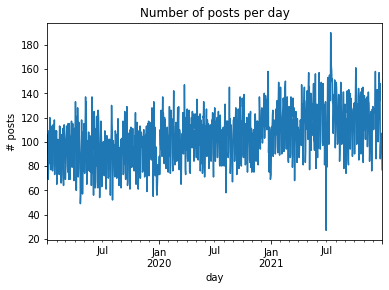

In [26]:
# plotting number of posts per day
df_message['Post Created - Day'] = df_message['Post Created'].dt.to_period('D')
date_day_size = df_message.groupby(['Post Created - Day']).size()
date_day_size.plot(ylabel='# posts',xlabel='day',title='Number of posts per day')

In [27]:
# extracting the year and the month of the datetime
df_message['Post Created - Year'] = df_message['Post Created'].dt.year
df_message['Post Created - Month'] = df_message['Post Created'].dt.month
df_message['Post Created - Year Month'] = df_message['Post Created'].dt.to_period('M')

<AxesSubplot:title={'center':'Number of posts per month'}, xlabel='month', ylabel='# posts'>

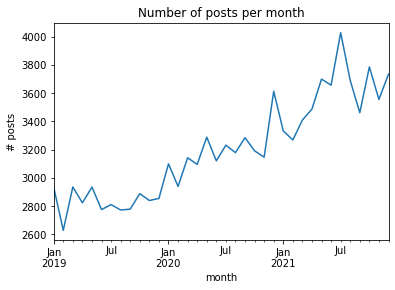

In [28]:
# number of posts per month
date_year_month_size = df_message.groupby(['Post Created - Year Month']).size()
date_year_month_size.plot(ylabel='# posts',xlabel='month',title='Number of posts per month')

<AxesSubplot:title={'center':'Number of posts per year'}, xlabel='year', ylabel='# posts'>

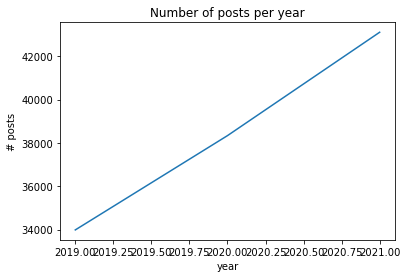

In [29]:
# number of posts per year
date_year_size = df_message.groupby(['Post Created - Year']).size()
date_year_size.plot(ylabel='# posts',xlabel='year',title='Number of posts per year')

<AxesSubplot:title={'center':'Number of posts per year'}, xlabel='year', ylabel='# posts'>

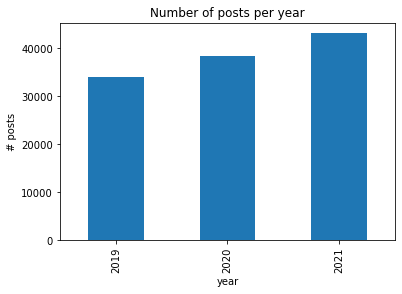

In [30]:
# number of posts per year
date_year_size = df_message.groupby(['Post Created - Year']).size()
date_year_size.plot.bar(ylabel='# posts',xlabel='year',title='Number of posts per year')

In [31]:
date_year_size

Post Created - Year
2019    33981
2020    38338
2021    43115
dtype: int64

In [32]:
# average post length
df_message['Post Length'] = [len(l) for l in df_message['Message']]
round(statistics.mean(df_message['Post Length']),2)

969.34

In [33]:
# is the URL a unique identifyer for the individual posts? -> yes
print(df_message["URL"].unique().shape)
dup_url = df_message["URL"].duplicated()
print(sum(dup_url))

(115434,)
0
